In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
import pandas as pd

# !head -n 20 imdb_data.csv
df = pd.read_csv('raw\imdb_data.csv', sep=';')
# df[df['origin_country'] == 'Japan']
df['release_date'].value_counts()


<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
C:\Users\andre\AppData\Local\Temp\ipykernel_9440\1909280709.py:4: SyntaxWarning: invalid escape sequence '\i'
  df = pd.read_csv('raw\imdb_data.csv', sep=';')


release_date
December 19, 1980 (United States)    7
March 22, 1985 (United States)       7
December 22, 2023 (United States)    7
December 16, 1983 (United States)    7
February 12, 1982 (United States)    6
                                    ..
March 7, 2025 (United States)        1
August 1975 (United States)          1
July 18, 1975 (United States)        1
June 6, 1975 (United States)         1
July 1975 (Canada)                   1
Name: count, Length: 2809, dtype: int64

In [4]:
df.isna().sum()

year                0
place               0
title               0
rating              1
min                 9
director            0
genre               0
release_date        1
origin_country      4
company            11
budget            741
gross_us          212
gross_world       175
open_week         529
dtype: int64

## Этап 1 Предварительная обработка (1.5 балла).
- Проанализируйте столбцы. Что в них содержится? Есть ли пропуски и где?
Обработайте пропуски, дубликаты, выбросы.
- Если в каком-то столбце пропусков большинство, то ее можно удалить.
- Сами пропуски/выбросы обработать: решите, удалить их или нет, заполнить медианой/средним или чем-нибудь еще, напишите, почему вы выбрали тот или иной вариант.


## Что делать с пропусками?
### НЕПРОБЛЕМНЫЕ

1. rating - 1, удалить
2. release_date - 1, удалить

3. origin_country и company - заменить пропуски на "Unknown"
- Остальные обработаем иначе.


In [5]:
df.dropna(subset='rating', inplace=True) #1
df.dropna(subset='release_date', inplace=True) #2

df = df.fillna({'origin_country': 'Unknown', 'company': 'Unknown'}) #3
df.isna().sum()

year                0
place               0
title               0
rating              0
min                 8
director            0
genre               0
release_date        0
origin_country      0
company             0
budget            739
gross_us          211
gross_world       174
open_week         527
dtype: int64

# ПРОБЛЕМНЫЕ
## budget, gross_us, gross_world, open_week - привести к int, убрать $, пропущенные данные остаются NaN




In [6]:

#1
import numpy as np

def str_to_int(x):
    s = str(x)
    digits = ''.join(ch for ch in s if ch.isdigit())
    return int(digits) if digits else np.nan

# приведение признаков, содержащих суммы денег к int
cash_columns = ['budget', 'gross_us', 'gross_world', 'open_week']
df[cash_columns] = df[cash_columns].apply(lambda x: x.apply(str_to_int))

df[cash_columns] = df[cash_columns].astype('Int64')


df.head(5)


,year,place,title,rating,min,director,genre,release_date,origin_country,company,budget,gross_us,gross_world,open_week
0,1975,1,Jaws,8.1,(124 min),Steven Spielberg,"['Disaster', 'Monster Horror', 'Sea Adventure'...","June 20, 1975 (United States)",United States,Zanuck/Brown Productions,7000000,280083300,490736300,7061513
1,1975,2,The Rocky Horror Picture Show,7.4,(100 min),Jim Sharman,"['B-Horror', 'Dark Comedy', 'Parody', 'Raunchy...","September 29, 1975 (United States)",United Kingdom,Twentieth Century Fox,1200000,113028197,116574698,135000
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,(133 min),Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...","November 21, 1975 (United States)",United States,Fantasy Films,3000000,108981275,109129807,<NA>
3,1975,4,Dog Day Afternoon,8.0,(125 min),Sidney Lumet,"['Dark Comedy', 'Heist', 'True Crime', 'Biogra...","December 25, 1975 (United States)",United States,Warner Bros.,1800000,50000000,50009617,<NA>
4,1975,5,Shampoo,6.4,(110 min),Hal Ashby,"['Satire', 'Comedy', 'Drama']","March 13, 1975 (United States)",United States,Persky-Bright / Vista,4000000,49407734,49407734,<NA>


## 2. release_date - удалить строки, а после привести формат June 20, 1975 (United States) ---> pd.to_datetime()


In [7]:
# приведение признака release_date к datetime
def clean_date(s):
    if pd.isna(s):
        return None
    # убираем страну в скобках, если есть
    if "(" in s:
        s = s.split("(")[0].strip()

    info = s.split()
    month_dict = {
        'January': 1, 'February': 2, 'March': 3,
        'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9,
        'October': 10, 'November': 11, 'December': 12
    }
    # June 20, 1975
    if len(info) == 3:
        month = info[0]
        day = info[1].replace(",", "")
        year = info[2]
    # July 1975
    elif len(info) == 2:
        month = info[0]
        day = "15"   # условно середина месяца
        year = info[1]
    else:
        return None  # на крайний случай

    return f"{year}-{month_dict[month]}-{day}"

df['release_date'] = pd.to_datetime(df['release_date'].apply(lambda x: clean_date(x)))

df.dropna(subset=['release_date'], inplace=True)

# создать признак month, как будет полезе при анализе сезонности релизов фильмов
df['release_month'] = df['release_date'].dt.month

df.head(5)


,year,place,title,rating,min,director,genre,release_date,origin_country,company,budget,gross_us,gross_world,open_week,release_month
0,1975,1,Jaws,8.1,(124 min),Steven Spielberg,"['Disaster', 'Monster Horror', 'Sea Adventure'...",1975-06-20,United States,Zanuck/Brown Productions,7000000,280083300,490736300,7061513,6
1,1975,2,The Rocky Horror Picture Show,7.4,(100 min),Jim Sharman,"['B-Horror', 'Dark Comedy', 'Parody', 'Raunchy...",1975-09-29,United Kingdom,Twentieth Century Fox,1200000,113028197,116574698,135000,9
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,(133 min),Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...",1975-11-21,United States,Fantasy Films,3000000,108981275,109129807,<NA>,11
3,1975,4,Dog Day Afternoon,8.0,(125 min),Sidney Lumet,"['Dark Comedy', 'Heist', 'True Crime', 'Biogra...",1975-12-25,United States,Warner Bros.,1800000,50000000,50009617,<NA>,12
4,1975,5,Shampoo,6.4,(110 min),Hal Ashby,"['Satire', 'Comedy', 'Drama']",1975-03-13,United States,Persky-Bright / Vista,4000000,49407734,49407734,<NA>,3


## 3. Приведение списка жанров к базовым (избавляемся от множества различных жанров, оставляем лишь базовые)

In [8]:

def make_genre_base(s):
    new_genre = []
    base_genres = ['comedy','musical', 'drama', 'horror', 
                   'action', 'romance', 'sci-fi', 'thriller', 
                   'documentary','adventure', 'animation', 'fantasy', 
                   'western']

    for g in base_genres:
        if g in ''.join(s.lower()):
            new_genre.append(g)
    return new_genre

df['genre_base'] = df['genre'].apply(lambda x: make_genre_base(x))



## 4. Приведение длительности (min), заполнение пропусков медианным значением, переименование признака в duration

In [9]:
df['min'] = df['min'].apply(lambda x: str_to_int(x))


df['min'] = df['min'].fillna(df['min'].median())
df = df.rename(columns={'min': 'duration'})
df['duration'] = df['duration'].astype('int64')

In [10]:
df.isna().sum()
df

,year,place,title,rating,duration,director,genre,release_date,origin_country,company,budget,gross_us,gross_world,open_week,release_month,genre_base
0,1975,1,Jaws,8.1,124,Steven Spielberg,"['Disaster', 'Monster Horror', 'Sea Adventure'...",1975-06-20,United States,Zanuck/Brown Productions,7000000,280083300,490736300,7061513,6,"[horror, thriller, adventure]"
1,1975,2,The Rocky Horror Picture Show,7.4,100,Jim Sharman,"['B-Horror', 'Dark Comedy', 'Parody', 'Raunchy...",1975-09-29,United Kingdom,Twentieth Century Fox,1200000,113028197,116574698,135000,9,"[comedy, musical, horror]"
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,133,Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...",1975-11-21,United States,Fantasy Films,3000000,108981275,109129807,<NA>,11,"[comedy, drama]"
3,1975,4,Dog Day Afternoon,8.0,125,Sidney Lumet,"['Dark Comedy', 'Heist', 'True Crime', 'Biogra...",1975-12-25,United States,Warner Bros.,1800000,50000000,50009617,<NA>,12,"[comedy, drama, thriller]"
4,1975,5,Shampoo,6.4,110,Hal Ashby,"['Satire', 'Comedy', 'Drama']",1975-03-13,United States,Persky-Bright / Vista,4000000,49407734,49407734,<NA>,3,"[comedy, drama]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4870,2025,96,Eternity,7.2,114,David Freyne,"['Feel-Good Romance', 'Romantic Comedy', 'Supe...",2025-11-26,United States,A24,<NA>,5236587,5433602,3169780,11,"[comedy, drama, romance, fantasy]"
4871,2025,97,Hurry Up Tomorrow,4.4,105,Trey Edward Shults,"['Psychological Thriller', 'Thriller']",2025-05-16,United States,Lionsgate,15000000,5215357,7763862,3312692,5,[thriller]
4872,2025,98,Light of the World,6.5,91,Tom Bancroft,"['Hand-Drawn Animation', 'Animation', 'Drama',...",2025-09-05,United States,The Salvation Poem Project,20000000,5213377,5604948,2401374,9,"[drama, animation]"
4873,2025,99,Chhaava,7.3,161,Laxman Utekar,"['Hindi', 'Action Epic', 'Costume Drama', 'Epi...",2025-02-14,India,Maddock Films,<NA>,4800000,8219603,1790000,2,"[drama, action]"


## 5. Больше всего пропусков в budget, gross_us, gross_world, open_week. Но их удаление исказит данные. Поэтому оставлю NaN и создам бинарные признаки has_budget, has_gross_us, has_gross_world, has_open_week. К которым будем обращаться при работе с этими признаками

In [11]:
cash_columns = ['budget', 'gross_us', 'gross_world', 'open_week']
for col in cash_columns:
    df[f'has_{col}'] = df[col].notna()

df.isna().sum()

year                 0
place                0
title                0
rating               0
duration             0
director             0
genre                0
release_date         0
origin_country       0
company              0
budget             735
gross_us           205
gross_world        169
open_week          519
release_month        0
genre_base           0
has_budget           0
has_gross_us         0
has_gross_world      0
has_open_week        0
dtype: int64

## 6. Проверка на дубликаты

In [12]:
df.duplicated(subset=['title', 'year']).sum()


np.int64(0)

## 7. Проверка на выбросы

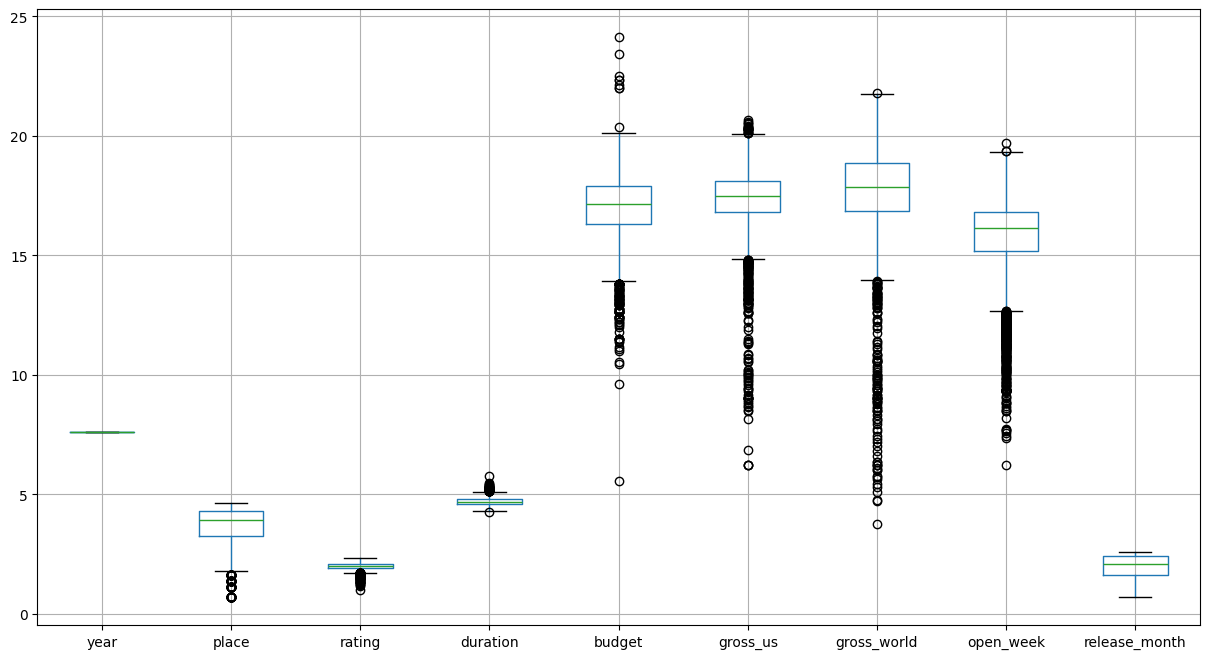

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# посмотрю на распределения всех числовых типов и опеределю, где необходимо удалять выбросы
# для наглядности распределения логарифмирую
num_df = df.select_dtypes(include=['number'])
log_df = num_df.apply(lambda col: np.log(col + 1) if col.min() >= 0 else col)

plt.figure(figsize=(15, 8))
log_df.boxplot()
plt.show()

- Всё что касается денег (budget, gross_us, gross_world, open_week) - выбросы удалять не стоит. Т.к. у денег бюджетов и сборов такая специфика.
- release_month не может содержать выбросов т.к. это нами созданный столбец с данными в диапазоне (1-12).
- Аналогично, год, место и рейтинг.
- Рассмотрим подробнее распределение duration


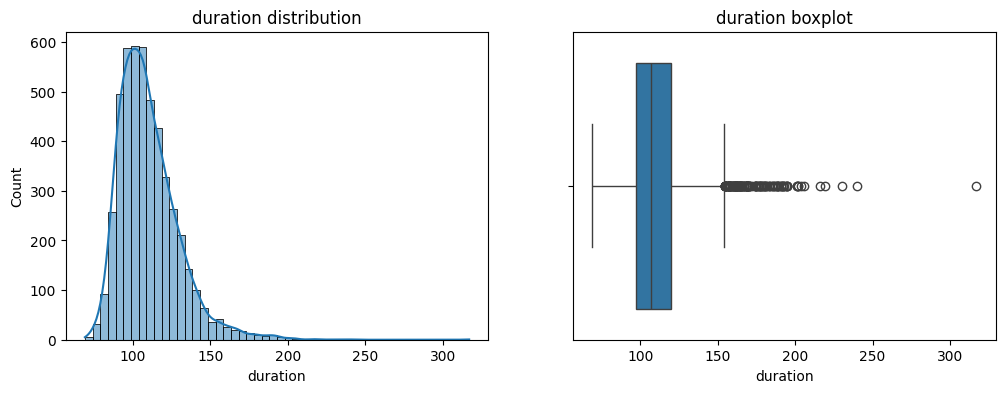

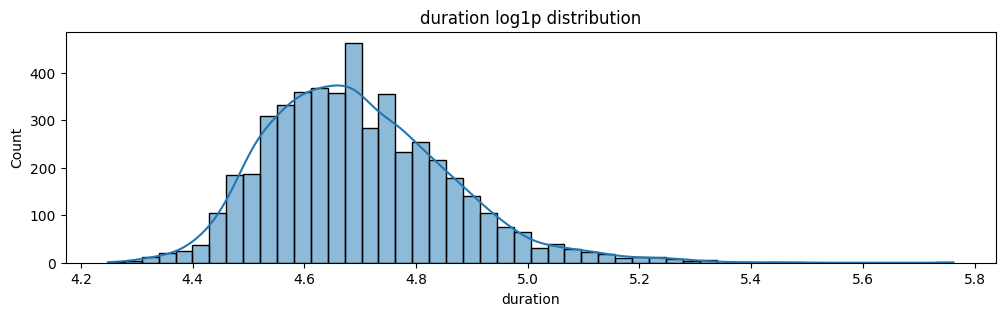

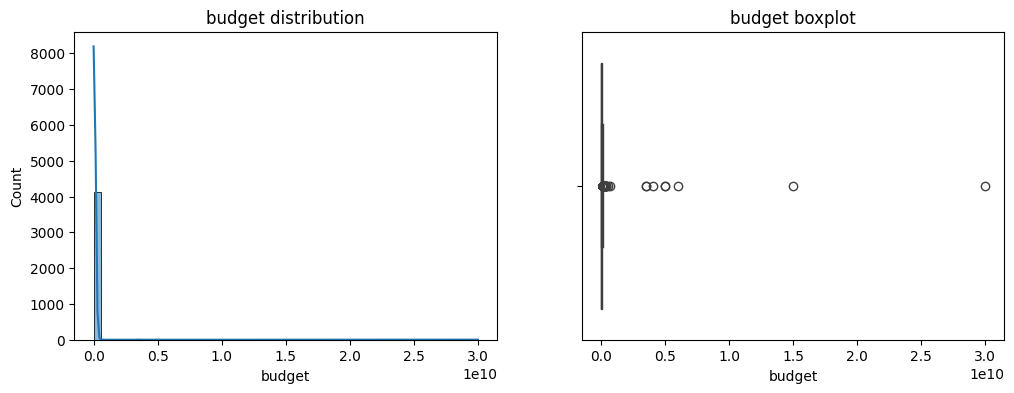

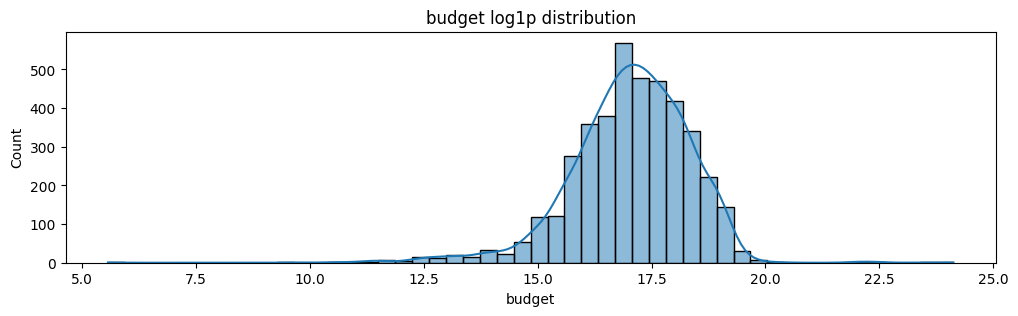

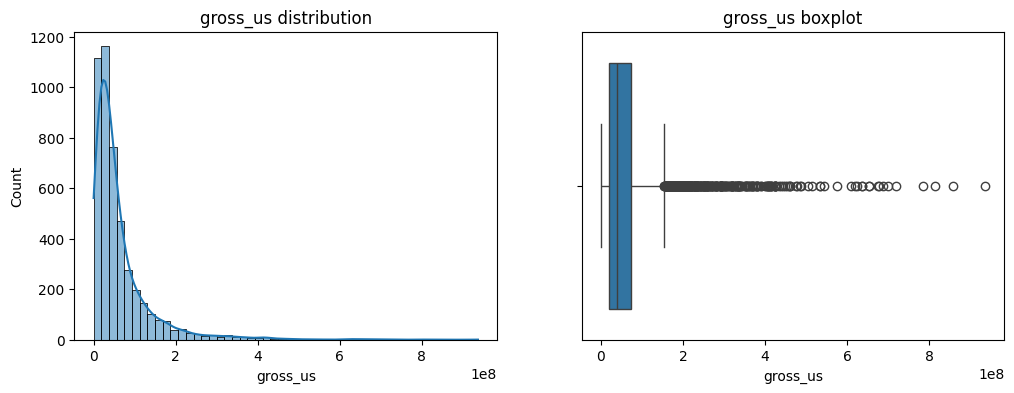

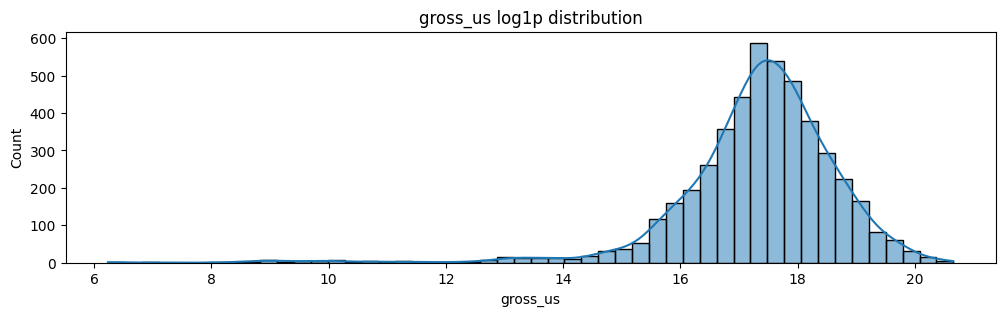

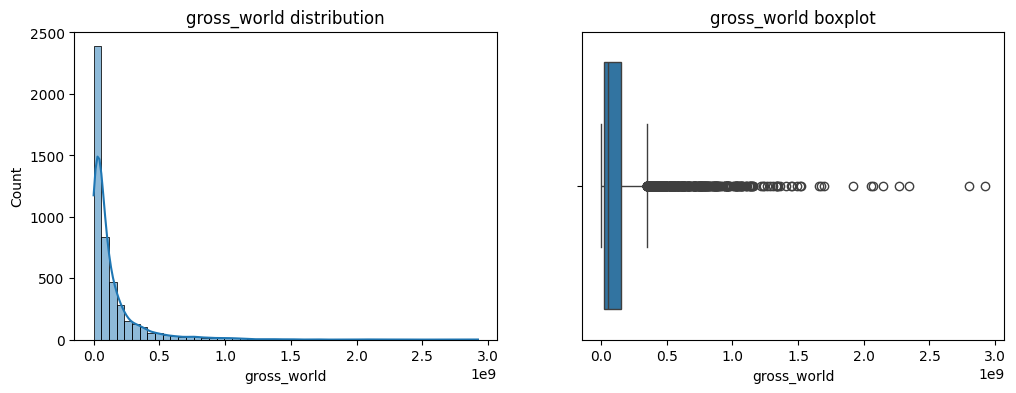

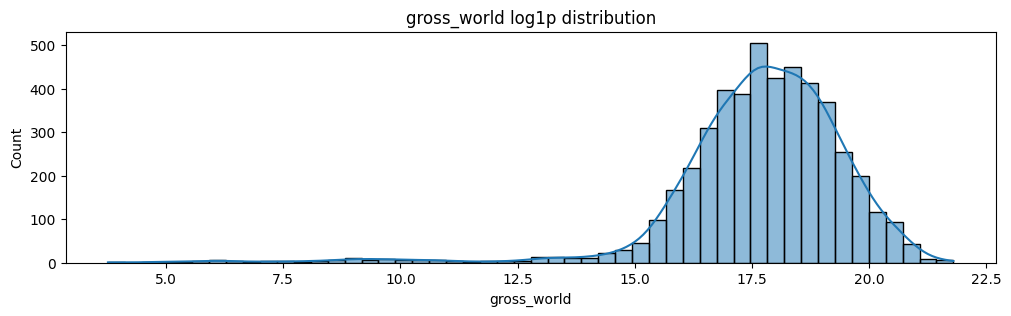

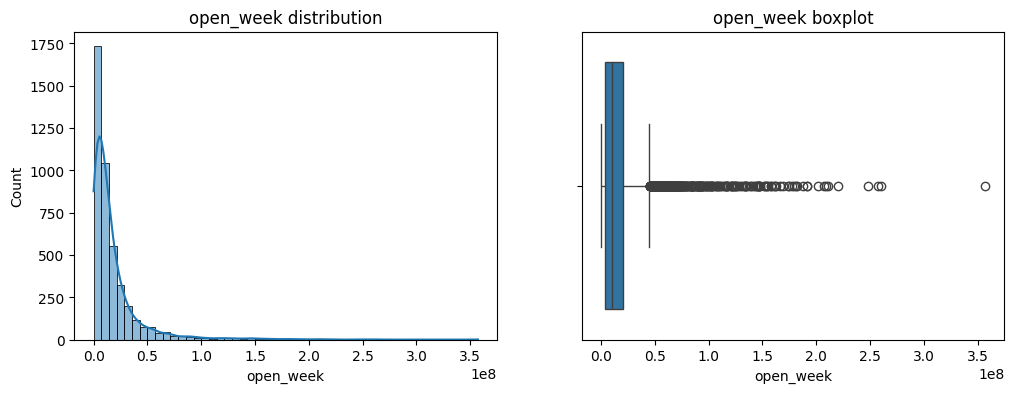

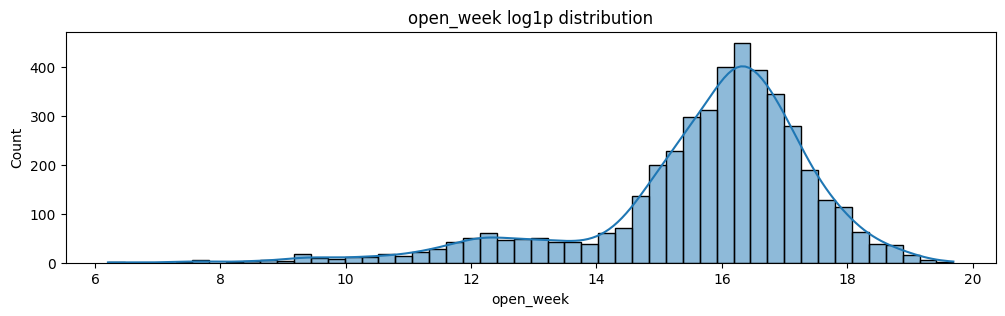

In [14]:


numeric_cols = ['duration','budget','gross_us','gross_world','open_week']

def plot_distributions(df, cols=numeric_cols, log_plot=True):
    for col in cols:
        s = df[col].dropna()
        if s.empty:
            continue
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        sns.histplot(s, bins=50, kde=True)
        plt.title(f'{col} distribution')
        plt.subplot(1,2,2)
        sns.boxplot(x=s)
        plt.title(f'{col} boxplot')
        plt.show()
        if log_plot:
            plt.figure(figsize=(12,3))
            sns.histplot(np.log1p(s), bins=50, kde=True)
            plt.title(f'{col} log1p distribution')
            plt.show()

plot_distributions(df, numeric_cols)

In [15]:
df

,year,place,title,rating,duration,director,genre,release_date,origin_country,company,budget,gross_us,gross_world,open_week,release_month,genre_base,has_budget,has_gross_us,has_gross_world,has_open_week
0,1975,1,Jaws,8.1,124,Steven Spielberg,"['Disaster', 'Monster Horror', 'Sea Adventure'...",1975-06-20,United States,Zanuck/Brown Productions,7000000,280083300,490736300,7061513,6,"[horror, thriller, adventure]",True,True,True,True
1,1975,2,The Rocky Horror Picture Show,7.4,100,Jim Sharman,"['B-Horror', 'Dark Comedy', 'Parody', 'Raunchy...",1975-09-29,United Kingdom,Twentieth Century Fox,1200000,113028197,116574698,135000,9,"[comedy, musical, horror]",True,True,True,True
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,133,Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...",1975-11-21,United States,Fantasy Films,3000000,108981275,109129807,<NA>,11,"[comedy, drama]",True,True,True,False
3,1975,4,Dog Day Afternoon,8.0,125,Sidney Lumet,"['Dark Comedy', 'Heist', 'True Crime', 'Biogra...",1975-12-25,United States,Warner Bros.,1800000,50000000,50009617,<NA>,12,"[comedy, drama, thriller]",True,True,True,False
4,1975,5,Shampoo,6.4,110,Hal Ashby,"['Satire', 'Comedy', 'Drama']",1975-03-13,United States,Persky-Bright / Vista,4000000,49407734,49407734,<NA>,3,"[comedy, drama]",True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4870,2025,96,Eternity,7.2,114,David Freyne,"['Feel-Good Romance', 'Romantic Comedy', 'Supe...",2025-11-26,United States,A24,<NA>,5236587,5433602,3169780,11,"[comedy, drama, romance, fantasy]",False,True,True,True
4871,2025,97,Hurry Up Tomorrow,4.4,105,Trey Edward Shults,"['Psychological Thriller', 'Thriller']",2025-05-16,United States,Lionsgate,15000000,5215357,7763862,3312692,5,[thriller],True,True,True,True
4872,2025,98,Light of the World,6.5,91,Tom Bancroft,"['Hand-Drawn Animation', 'Animation', 'Drama',...",2025-09-05,United States,The Salvation Poem Project,20000000,5213377,5604948,2401374,9,"[drama, animation]",True,True,True,True
4873,2025,99,Chhaava,7.3,161,Laxman Utekar,"['Hindi', 'Action Epic', 'Costume Drama', 'Epi...",2025-02-14,India,Maddock Films,<NA>,4800000,8219603,1790000,2,"[drama, action]",False,True,True,True


In [16]:
df.dtypes

year                        int64
place                       int64
title                      object
rating                    float64
duration                    int64
director                   object
genre                      object
release_date       datetime64[ns]
origin_country             object
company                    object
budget                      Int64
gross_us                    Int64
gross_world                 Int64
open_week                   Int64
release_month               int32
genre_base                 object
has_budget                   bool
has_gross_us                 bool
has_gross_world              bool
has_open_week                bool
dtype: object

In [17]:
df.to_csv('cleaned\imdb_data_cleaned.csv', sep=';', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\andre\AppData\Local\Temp\ipykernel_9440\3886221927.py:1: SyntaxWarning: invalid escape sequence '\i'
  df.to_csv('cleaned\imdb_data_cleaned.csv', sep=';', index=False)
